This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Example for georeferencing a radar dataset

In [1]:
import wradlib as wrl
import xarray as xr
import xradar as xd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

**1st step:** Compute centroid coordinates and vertices of all radar bins in WGS84 (longitude and latitude).

In [2]:
swp = (
    xd.model.create_sweep_dataset(rng=1000)
    .swap_dims(time="azimuth")
    .isel(range=slice(0, 100))
)
swp = swp.assign_coords(sweep_mode="azimuthal_surveillance")
swp = swp.wrl.georef.georeference()
swp

<xarray.Dataset> Size: 2MB
Dimensions:     (azimuth: 360, range: 100)
Coordinates: (12/15)
    time        (azimuth) datetime64[ns] 3kB 2022-08-27T10:00:00 ... 2022-08-...
  * range       (range) float64 800B 500.0 1.5e+03 2.5e+03 ... 9.85e+04 9.95e+04
  * azimuth     (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 3kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    longitude   float64 8B 8.788
    latitude    float64 8B 46.17
    ...          ...
    y           (azimuth, range) float64 288kB 499.9 1.5e+03 ... 9.945e+04
    z           (azimuth, range) float64 288kB 383.7 401.3 ... 2.694e+03
    gr          (azimuth, range) float64 288kB 499.9 1.5e+03 ... 9.946e+04
    rays        (azimuth, range) float64 288kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    bins        (azimuth, range) float64 288kB 500.0 1.5e+03 ... 9.95e+04
    crs_wkt     int64 8B 0
Data variables:
    *empty*

We can now generate the polgon vertices of the radar bins - with **each vertex in lon/lat coordinates**.

In [3]:
proj_wgs84 = wrl.georef.epsg_to_osr(4326)
polygons = swp.wrl.georef.spherical_to_polyvert(crs=proj_wgs84, keep_attrs=True)
polygons

<xarray.DataArray 'spherical_to_polyvert' (bins: 36000, vert: 5, xy: 3)> Size: 4MB
array([[[   8.787727  ,   46.172541  ,  375.        ],
        [   8.787727  ,   46.18153568,  392.51128273],
        [   8.78795299,   46.18153431,  392.51128273],
        [   8.787727  ,   46.172541  ,  375.        ],
        [   8.787727  ,   46.172541  ,  375.        ]],

       [[   8.787727  ,   46.18153568,  392.51128273],
        [   8.787727  ,   46.19053031,  410.14031758],
        [   8.78817906,   46.19052756,  410.14031758],
        [   8.78795299,   46.18153431,  392.51128273],
        [   8.787727  ,   46.18153568,  392.51128273]],

       [[   8.787727  ,   46.19053031,  410.14031758],
        [   8.787727  ,   46.19952488,  427.8871038 ],
        [   8.7884052 ,   46.19952077,  427.8871038 ],
        [   8.78817906,   46.19052756,  410.14031758],
        [   8.787727  ,   46.19053031,  410.14031758]],

       ...,

       [[   8.76546085,   47.04461365, 2621.72317735],
        [   8.76522761,   47.05360076, 2650.65223704],
        [   8.78772694,   47.05373714, 2650.65223704],
        [   8.78772694,   47.04474861, 2621.72317735],
        [   8.76546085,   47.04461365, 2621.72317735]],

       [[   8.76522761,   47.05360076, 2650.65223704],
        [   8.76499429,   47.06258781, 2679.69900768],
        [   8.78772694,   47.0627256 , 2679.69900768],
        [   8.78772694,   47.05373714, 2650.65223704],
        [   8.76522761,   47.05360076, 2650.65223704]],

       [[   8.76499429,   47.06258781, 2679.69900768],
        [   8.76476089,   47.07157477, 2708.86342778],
        [   8.78772694,   47.07171398, 2708.86342778],
        [   8.78772694,   47.0627256 , 2679.69900768],
        [   8.76499429,   47.06258781, 2679.69900768]]],
      shape=(36000, 5, 3))
Coordinates:
    longitude   float64 8B 8.788
    latitude    float64 8B 46.17
    altitude    int64 8B 375
    sweep_mode  <U22 88B 'azimuthal_surveillance'
    crs_wkt     int64 8B 0
Dimensions without coordinates: bins, vert, xy

... or we can compute the corresponding centroids of all bins -  - with **each centroid in lon/lat coordinates**.

In [4]:
centroids = swp.wrl.georef.spherical_to_centroids(crs=proj_wgs84, keep_attrs=True)
centroids

<xarray.DataArray 'spherical_to_centroids' (azimuth: 360, range: 100, xyz: 3)> Size: 864kB
array([[[   8.7877835 ,   46.17703817,  383.74092231],
        [   8.78789652,   46.18603248,  401.31108119],
        [   8.78800957,   46.19502674,  418.99899181],
        ...,
        [   8.79891893,   47.04920895, 2636.17297817],
        [   8.79903558,   47.05819709, 2665.16095378],
        [   8.79915226,   47.06718516, 2694.26651916]],

       [[   8.78789647,   46.1770368 ,  383.74092231],
        [   8.7882355 ,   46.18602837,  401.31108119],
        [   8.78857463,   46.19501989,  418.99899181],
        ...,
        [   8.82129918,   47.04893762, 2636.17297817],
        [   8.82164908,   47.05792293, 2665.16095378],
        [   8.82199909,   47.06690816, 2694.26651916]],

       [[   8.7880094 ,   46.17703406,  383.74092231],
        [   8.78857432,   46.18602015,  401.31108119],
        [   8.78913943,   46.19500619,  418.99899181],
        ...,
...
        [   8.73178512,   47.048395  , 2636.17297817],
        [   8.73120208,   47.05737466, 2665.16095378],
        [   8.73061885,   47.06635424, 2694.26651916]],

       [[   8.78755753,   46.1770368 ,  383.74092231],
        [   8.78721851,   46.18602837,  401.31108119],
        [   8.78687937,   46.19501989,  418.99899181],
        ...,
        [   8.75415509,   47.04893762, 2636.17297817],
        [   8.75380519,   47.05792293, 2665.16095378],
        [   8.75345518,   47.06690816, 2694.26651916]],

       [[   8.7876705 ,   46.17703817,  383.74092231],
        [   8.78755749,   46.18603248,  401.31108119],
        [   8.78744443,   46.19502674,  418.99899181],
        ...,
        [   8.77653518,   47.04920895, 2636.17297817],
        [   8.77641854,   47.05819709, 2665.16095378],
        [   8.77630185,   47.06718516, 2694.26651916]]],
      shape=(360, 100, 3))
Coordinates:
  * range       (range) float64 800B 500.0 1.5e+03 2.5e+03 ... 9.85e+04 9.95e+04
    longitude   float64 8B 8.788
    latitude    float64 8B 46.17
    altitude    int64 8B 375
    sweep_mode  <U22 88B 'azimuthal_surveillance'
    crs_wkt     int64 8B 0
    time        (azimuth) datetime64[ns] 3kB 2022-08-27T10:00:00 ... 2022-08-...
  * azimuth     (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 3kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Dimensions without coordinates: xyz

In order to understand how vertices and centroids correspond, we can plot them together.

(46.422541, 46.56147892646726)

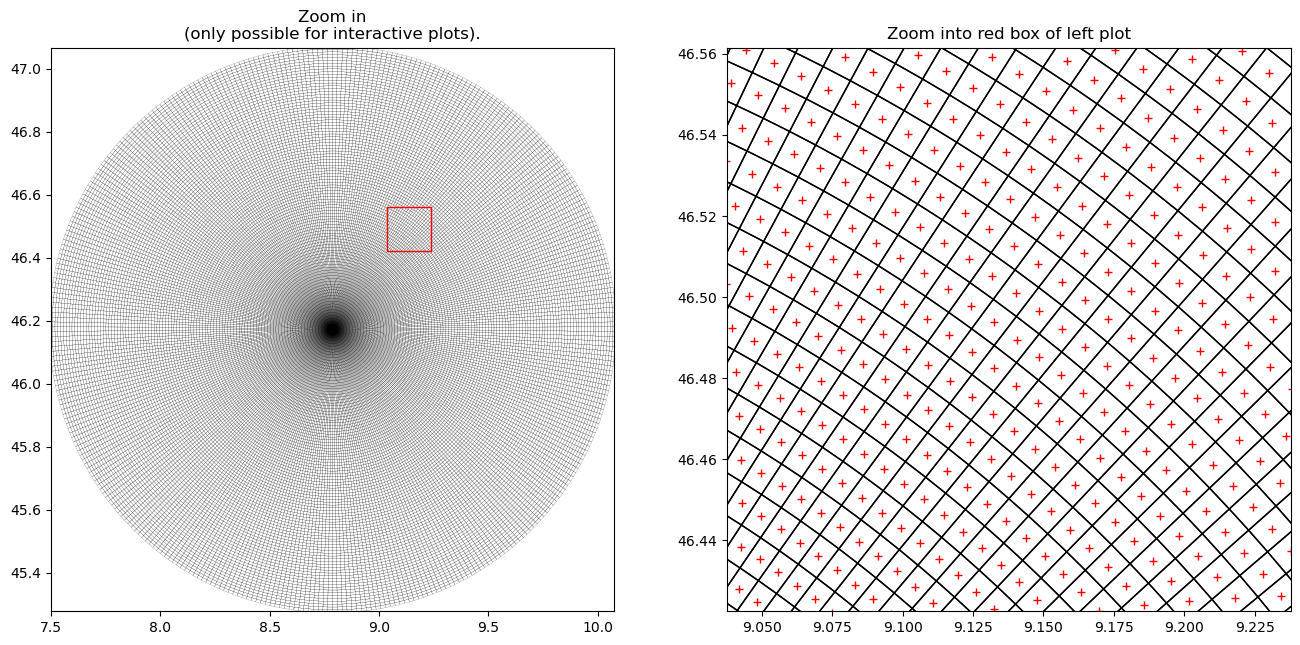

In [5]:
fig = plt.figure(figsize=(16, 16))
site = (polygons.longitude.values, polygons.latitude.values)

aspect = (centroids[..., 0].max() - centroids[..., 0].min()) / (
    centroids[..., 1].max() - centroids[..., 1].min()
)
ax = fig.add_subplot(121, aspect=aspect)
polycoll = mpl.collections.PolyCollection(
    polygons.isel(xy=slice(0, 2)), closed=True, facecolors="None", linewidth=0.1
)
ax.add_collection(polycoll, autolim=True)
# ax.plot(centroids[..., 0], centroids[..., 1], 'r+')
plt.title("Zoom in\n(only possible for interactive plots).")
ax.add_patch(
    Rectangle(
        (site[0] + 0.25, site[1] + 0.25),
        0.2,
        0.2 / aspect,
        edgecolor="red",
        facecolor="None",
        zorder=3,
    )
)
plt.xlim(centroids[..., 0].min(), centroids[..., 0].max())
plt.ylim(centroids[..., 1].min(), centroids[..., 1].max())

ax = fig.add_subplot(122, aspect=aspect)
polycoll = mpl.collections.PolyCollection(
    polygons.isel(xy=slice(0, 2)), closed=True, facecolors="None"
)
ax.add_collection(polycoll, autolim=True)
ax.plot(centroids[..., 0], centroids[..., 1], "r+")
plt.title("Zoom into red box of left plot")
plt.xlim(site[0] + 0.25, site[0] + 0.25 + 0.2)
plt.ylim(site[1] + 0.25, site[1] + 0.25 + 0.2 / aspect)

**2nd step:** Reproject the centroid coordinates to Gauss-Krueger Zone 3 (i.e. EPSG-Code 31467).

In [6]:
centroids_xyz = centroids.assign_coords(xyz=["x", "y", "z"]).to_dataset("xyz")
centroids_xyz

<xarray.Dataset> Size: 874kB
Dimensions:     (azimuth: 360, range: 100)
Coordinates:
  * range       (range) float64 800B 500.0 1.5e+03 2.5e+03 ... 9.85e+04 9.95e+04
    longitude   float64 8B 8.788
    latitude    float64 8B 46.17
    altitude    int64 8B 375
    sweep_mode  <U22 88B 'azimuthal_surveillance'
    crs_wkt     int64 8B 0
    time        (azimuth) datetime64[ns] 3kB 2022-08-27T10:00:00 ... 2022-08-...
  * azimuth     (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 3kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Data variables:
    x           (azimuth, range) float64 288kB 8.788 8.788 8.788 ... 8.776 8.776
    y           (azimuth, range) float64 288kB 46.18 46.19 46.2 ... 47.06 47.07
    z           (azimuth, range) float64 288kB 383.7 401.3 ... 2.694e+03

In [7]:
proj_gk3 = wrl.georef.epsg_to_osr(31467)
centroids_xyz = centroids_xyz.wrl.georef.reproject(trg_crs=proj_gk3)
centroids_xyz

<xarray.Dataset> Size: 874kB
Dimensions:     (azimuth: 360, range: 100)
Coordinates:
    x           (azimuth, range) float64 288kB 3.484e+06 3.484e+06 ... 3.484e+06
    y           (azimuth, range) float64 288kB 5.115e+06 5.115e+06 ... 5.115e+06
    z           (azimuth, range) float64 288kB 383.7 401.3 ... 2.694e+03
  * range       (range) float64 800B 500.0 1.5e+03 2.5e+03 ... 9.85e+04 9.95e+04
    longitude   float64 8B 8.788
    latitude    float64 8B 46.17
    altitude    int64 8B 375
    sweep_mode  <U22 88B 'azimuthal_surveillance'
    crs_wkt     int64 8B 0
    time        (azimuth) datetime64[ns] 3kB 2022-08-27T10:00:00 ... 2022-08-...
  * azimuth     (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 3kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Data variables:
    *empty*